# Modules

In [1]:
%load_ext autoreload
%autoreload 1

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

from collections import Counter, defaultdict, OrderedDict
import multiprocessing as mp
import pickle

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

%aimport ase_matrix
%aimport classification
%aimport toolkit
%aimport util
%aimport workspace_manager

sns.set()

workspace = {}
for data_type in ["scDNA", "scRNA"]:
    workspace.update({ 
        data_type : workspace_manager.WorkspaceManager(
            task_name="ase_to_cnv",
            experiment_info={"data" : data_type},
            verbose=True
        )
    })
    workspace[data_type].load_workspace()

# Loading workspace

In [1]:
clustering_tag = {
    "scDNA" : "evo_dist_9",
    "scRNA" : "seurat"
}
filtering_tag = "PC1_PC2_span_75%"
data = {}
for data_type in ["scDNA", "scRNA"]:
    data[data_type] = {
        data_name :
        util.pickle_load(data_dump)
        for data_name, data_dump in tqdm_notebook(
            workspace[data_type].tmp_data.items(),
            f"{data_type}, loading datasets into RAM"
        )
    }

NameError: name 'tqdm_notebook' is not defined

# Runtime

In [3]:
%%time

ase_info = {
    data_type : data[data_type]["ase"]
    for data_type in workspace.keys()
}

gene_counts_info = {
    data_type : data[data_type]["gene_counts"]
    for data_type in workspace.keys()
}

clustering_info = {
    data_type : data[data_type]["clustering"]
    for data_type in workspace.keys()
}

for data_type in workspace.keys():
    ase_info[data_type]["GENE_ID"] = gene_counts_info[data_type]["GENE_ID"]

common_genes = (set(gene_counts_info["scDNA"].GENE_ID) 
                & set(gene_counts_info["scRNA"].GENE_ID))

print("Datasets have {} genes in common".format(len(common_genes)))

for data_type in workspace.keys():
    ase_info[data_type] = util.filter_by_isin(
        ase_info[data_type], 
        "GENE_ID", 
        common_genes
    ).reset_index(drop=True)
    gene_counts_info[data_type] = util.filter_by_isin(
        gene_counts_info[data_type], 
        "GENE_ID", 
        common_genes
    ).reset_index(drop=True)
    
assert gene_counts_info["scRNA"].shape[0] == gene_counts_info["scDNA"].shape[0]

Datasets have 2655 genes in common
CPU times: user 0 ns, sys: 4.25 s, total: 4.25 s
Wall time: 7.19 s


/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/lib/classification.py:24: RuntimeWarning: invalid value encountered in greater
  (((profile > 0) | (Nm == 0)) * Nm * np.log(profile)).dropna().values.sum()
/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/lib/classification.py:24: RuntimeWarning: divide by zero encountered in log
  (((profile > 0) | (Nm == 0)) * Nm * np.log(profile)).dropna().values.sum()
/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/lib/classification.py:25: RuntimeWarning: invalid value encountered in less
  + (((profile < 1) | (Np == 0)) * Np * np.log(1 - profile)).dropna().values.sum()
/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/lib/classification.py:25: RuntimeWarning: divide by zero encountered in log
  + (((profile < 1) | (Np == 0)) * Np * np.log(1 - profile)).dropna().values.sum()



CPU times: user 12.5 s, sys: 8.41 s, total: 20.9 s
Wall time: 14 s


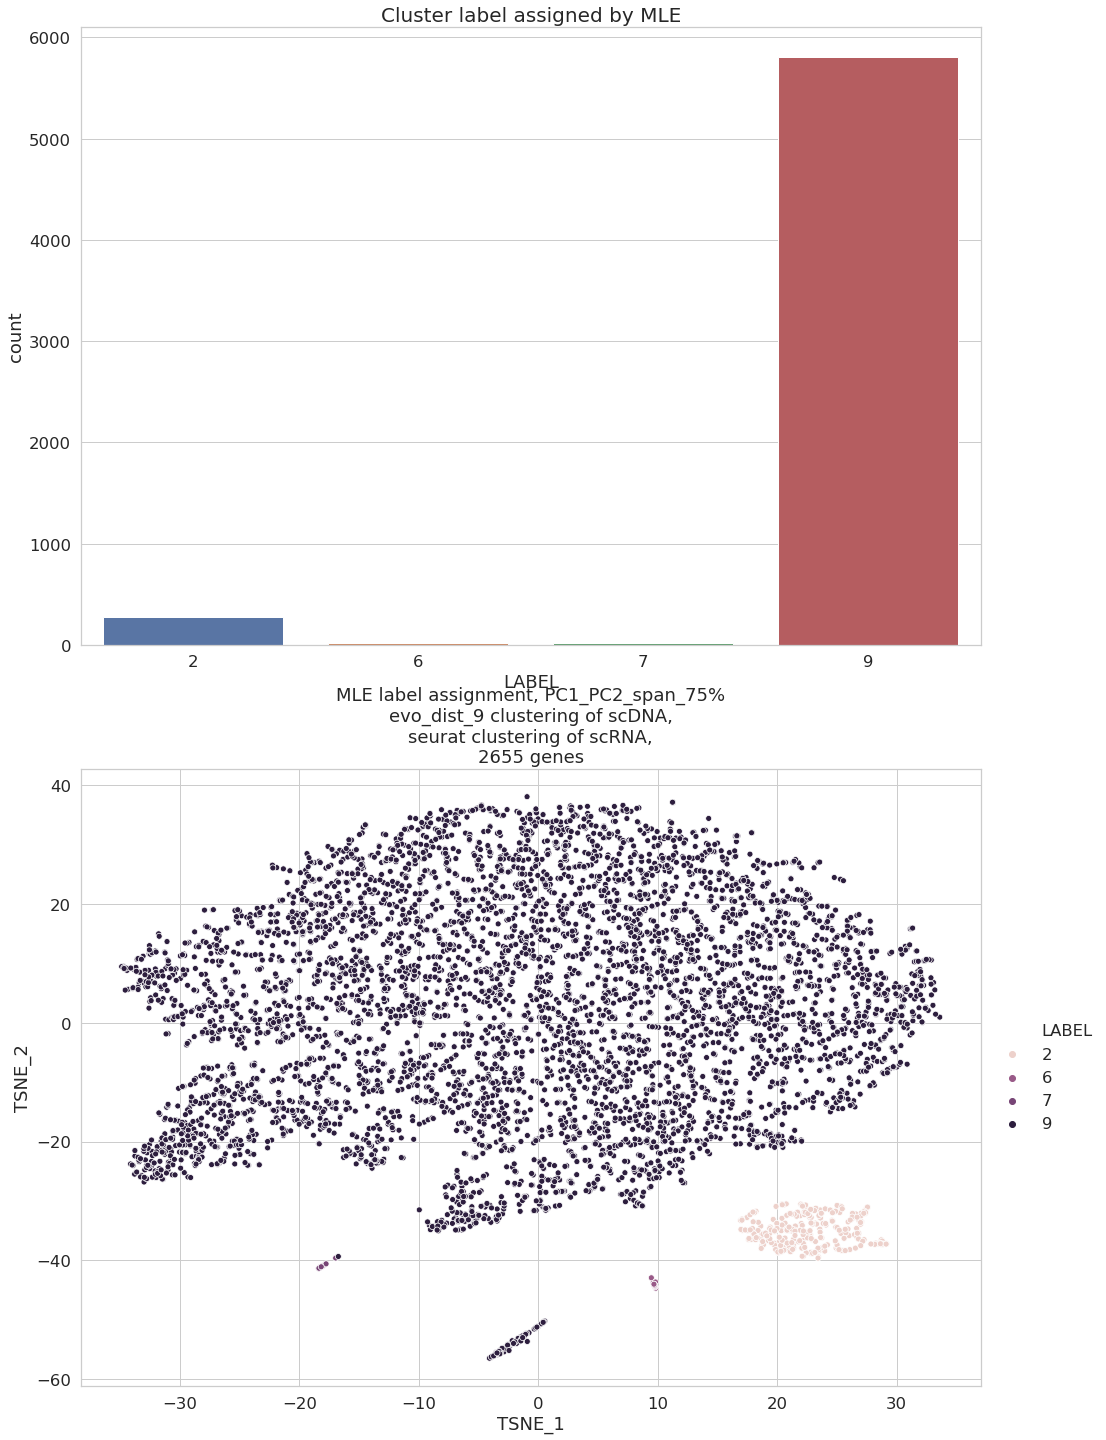

In [4]:
%%time
clf = classification.AseMleClassifier(
    clustering_info['scDNA'], 
    clustering_info['scRNA']
)

clustered_scRNA_counts_df = toolkit.aggregate_by_barcode_groups(
    gene_counts_info["scRNA"],
    clustering_info["scRNA"],
    verbose=True
)

labels = clf.predict(
    clustered_scRNA_counts_df, 
    ase_info["scDNA"]
)

clf.classification_report(
    clustering_info["scRNA"].LABEL.apply(lambda i: labels[i] + 1), 
    title=f"MLE label assignment, {filtering_tag}\n"
            f"{clustering_tag['scDNA']} clustering of scDNA,\n"
            f"{clustering_tag['scRNA']} clustering of scRNA,\n"
            f"{gene_counts_info['scRNA'].shape[0]} genes",
    outfile=f"{workspace['scRNA'].img_dir}"
            f"/{filtering_tag}_{clustering_tag['scDNA']}"
            f"_{clustering_tag['scRNA']}_MLE_labels.pdf"
    
)